# Data exploration

In [1]:
!python3 scrapping_scripts/scrap_all.py

Searching for data/singles_lists/top_fr_1961_1993.tsv
Found
Searching for data/singles_lists/top_fr_1994_2020.tsv
Found
Searching for data/singles_lists/top_uk_1953_2004.tsv
Found
Searching for data/singles_lists/top_uk_2005_2020.tsv
Found
Searching for data/singles_lists/top_us_1950_2015.tsv
Found
Searching for data/lyrics/fr_1961_1993.json
Found
Searching for data/lyrics/fr_1994_2020.json
Found
Searching for data/lyrics/uk_1953_2004.json
Found
Searching for data/lyrics/uk_2005_2020.json
Found
Searching for data/lyrics/us_1950_2015.json
Found


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycld2 as cld2
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from langdetect import detect as langdetect
from tqdm.notebook import trange, tqdm
sns.set_theme()

## Loading the scraped datasets

In [3]:
DATA_DIR = "data/"

In [4]:
df = pd.read_json(DATA_DIR + "all_lyrics.json")
df['lyrics_state'] = df['lyrics_state'].apply(lambda state: 0 if state == "missing" else 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17286 entries, 0 to 17285
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          17286 non-null  int64 
 1   artist        17286 non-null  object
 2   title         17286 non-null  object
 3   lyrics        16236 non-null  object
 4   lyrics_state  17286 non-null  int64 
 5   country       17286 non-null  object
dtypes: int64(2), object(4)
memory usage: 945.3+ KB


In [5]:
df.head()

,year,artist,title,lyrics,lyrics_state,country
0,2005,tony christie ft peter kay,(is this the way to) amarillo,July 2020 Singles Release Calendar Lyrics7/1\n...,1,uk
1,2005,shayne ward,that's my goal,"That’s My Goal Lyrics\nYeah, you know where I'...",1,uk
2,2005,crazy frog,axel f,Axel F Lyrics\nRing ding ding daa baa\nBaa ara...,1,uk
3,2005,james blunt,you're beautiful,You’re Beautiful Lyrics\nMy life is brilliant\...,1,uk
4,2005,pussycat dolls ft busta rhymes,don't cha,"Don’t Cha Lyrics\nOkay (Ahh)\nYeah (Ahh)\nOh, ...",1,uk


## Singles per year

Text(0, 0.5, 'Number of artists')

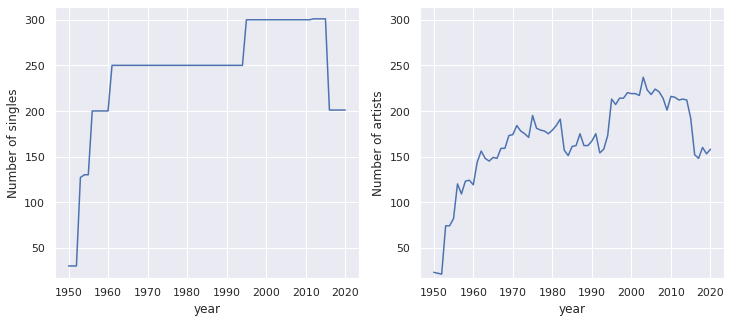

In [6]:
yearly_df = df.groupby('year')
plt.figure(figsize=(12, 5))

# Plots the number of titles per year
ax = plt.subplot(121)
yearly_titles = yearly_df.count()['title']
yearly_titles.plot(ax=ax)
ylim = ax.get_ylim()
plt.ylabel('Number of singles')

# Plots the number of unique artists per year
ax = plt.subplot(122)
yearly_df.artist.nunique().plot(ax=ax)
# Sets the same ylim as for the first plot
ax.set_ylim(ylim)

plt.ylabel('Number of artists')

## Missing data

In [7]:
def yearly_missing_info(df, country=None):
    """
    Returns a dataframe containing the number of titles, number of titles
    with complete lyrics, number of missing lyrics and the proportions of
    titles whose lyrics are missing.
    """
    # Filter by country if required
    if country is not None:
        df = df[df['country'] == country]
    
    yearly_df = df.groupby('year')
    # Yearly count of titles
    yearly_titles = yearly_df.count()['title']

    # Yearly count of songs with complete lyrics
    yearly_complete_lyrics = yearly_df.sum()['lyrics_state']
    # Yearly proportions of songs whose lyrics are not missing
    yearly_missing_proportion = 1 - (yearly_complete_lyrics / yearly_titles)

    yearly_df = pd.DataFrame({'titles_count': yearly_titles, 'complete': yearly_complete_lyrics, 'missing': yearly_titles - yearly_complete_lyrics,
                              'missing_proportion': yearly_missing_proportion})
    return yearly_df

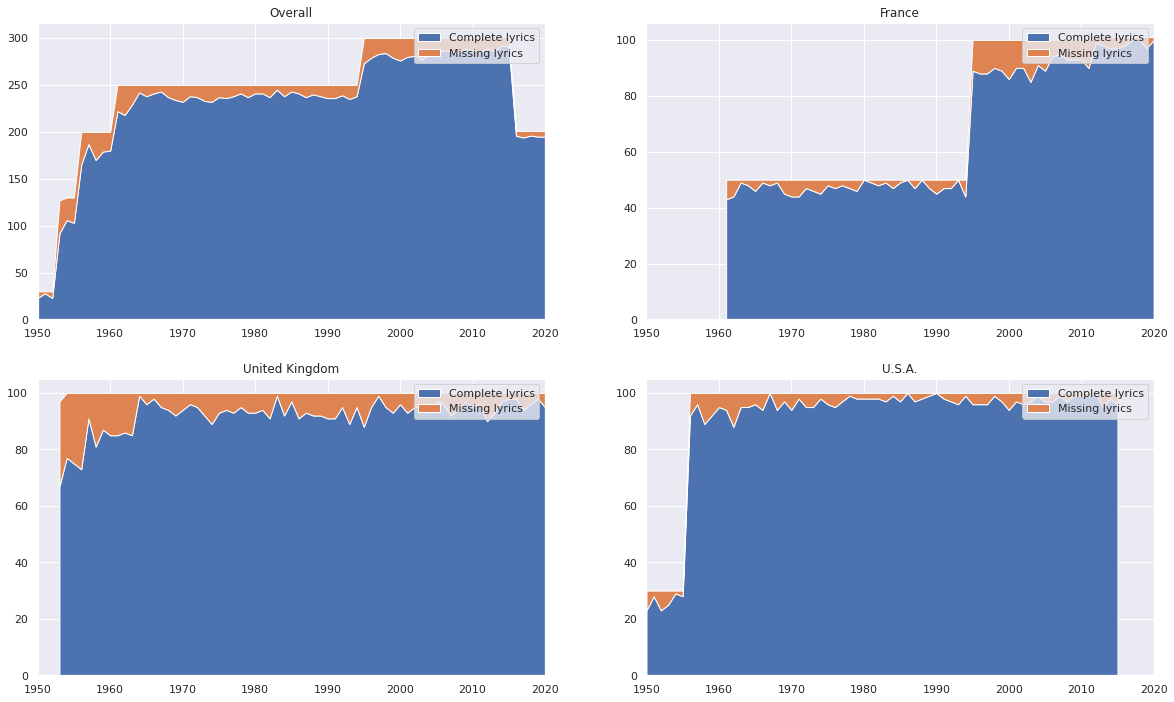

In [8]:
plt.figure(figsize=(20, 12))

def plot_missing_lyrics(ax, title, country=None):
    yearly_df = yearly_missing_info(df, country=country)
    plt.stackplot(yearly_df.index,
                  yearly_df['complete'], yearly_df['missing'],
                  baseline ='zero')
    plt.legend(['Complete lyrics', 'Missing lyrics'])
    plt.xlim(1950, 2020)
    ax.set_title(title)
    
# Plots the proportions of missing lyrics overall and separately for every country
ax = plt.subplot(221)
plot_missing_lyrics(ax, "Overall")
ax = plt.subplot(222)
plot_missing_lyrics(ax, "France", country="fr")
ax = plt.subplot(223)
plot_missing_lyrics(ax, "United Kingdom", country="uk")
ax = plt.subplot(224)
plot_missing_lyrics(ax, "U.S.A.", country="us")

plt.show()

## First cleaning
We first need to apply some basic cleaning on the lyrics. Let's print some of the lyrics:

In [9]:
# We discard the songs whose lyrics are missing
lyrics_df = df[df['lyrics_state'] == 1].drop('lyrics_state', axis=1)

In [10]:
lyrics_df.head()

,year,artist,title,lyrics,country
0,2005,tony christie ft peter kay,(is this the way to) amarillo,July 2020 Singles Release Calendar Lyrics7/1\n...,uk
1,2005,shayne ward,that's my goal,"That’s My Goal Lyrics\nYeah, you know where I'...",uk
2,2005,crazy frog,axel f,Axel F Lyrics\nRing ding ding daa baa\nBaa ara...,uk
3,2005,james blunt,you're beautiful,You’re Beautiful Lyrics\nMy life is brilliant\...,uk
4,2005,pussycat dolls ft busta rhymes,don't cha,"Don’t Cha Lyrics\nOkay (Ahh)\nYeah (Ahh)\nOh, ...",uk


We can first notice that all songs start with a line "SONG NAME Lyrics", which we should remove:

In [11]:
def remove_Lyrics_line(lyrics):
    """
    Removes the beginning of a song lyrics until the "Lyrics" word is found.
    """
    pos = lyrics.find('Lyrics')
    if pos != -1:
        return lyrics[pos + 6:]

In [12]:
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(remove_Lyrics_line)

## Non-songs items
Some items are not songs lyrics but list of songs, for some reason. This is admitted by the python GENIUS api and cannot be avoided as long as we use their api.

In [13]:
lyrics_lengths = lyrics_df['lyrics'].apply(lambda text: len(text.split(' ')))

Text(0.5, 0, "Number of words in the 'lyrics'")

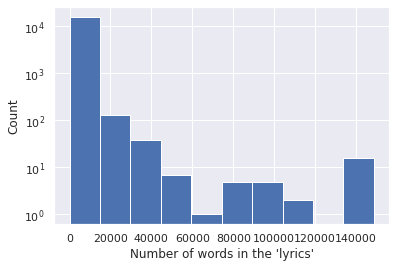

In [14]:
lyrics_lengths.hist(log=True)
plt.ylabel("Count")
plt.xlabel("Number of words in the 'lyrics'")

Over a hundred "songs" are longer than 20000 words, which is of course unrealistic. Actually it even contains memoires, such as "Angela's Ashes" by Frank McCourt.  
To remove those, we'll filter the songs whose lyrics are longer than an arbitrary limit, let's say 1000 words.

In [15]:
lyrics_df = lyrics_df[lyrics_lengths < 1000]

Text(0.5, 0, "Number of words in the 'lyrics'")

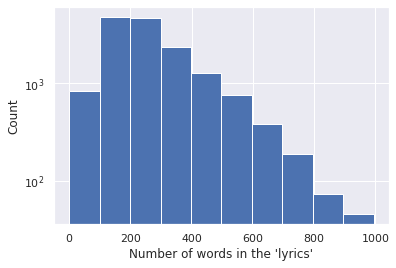

In [16]:
lyrics_lengths = lyrics_df['lyrics'].apply(lambda text: len(text.split(' ')))
lyrics_lengths.hist(log=True)
plt.ylabel("Count")
plt.xlabel("Number of words in the 'lyrics'")

# Language classification
We'll now need to detect the language of every song in order to run the LDA. To do so we don't need to divide the data
by country.  
We'll use the python module ```langdetect```.

## Detection

In [ ]:
languages = []
# For every song, detect its language
for row, lyrics in zip(trange(lyrics_df.shape[0]), lyrics_df['lyrics']):
    languages.append(langdetect(lyrics))
lyrics_df['lang'] = languages

## Analysis
Let's first have a look at the songs which were detected as neither in french or english:

In [ ]:
lyrics_df[~lyrics_df['lang'].isin(['fr', 'en'])]

For now we'll discard those songs as they represent a tiny portion of the total dataset. Nonetheless this list contains errors (for example, Justin Bieber's "Baby" is counted as portuguese, becaused GENIUS.com returned a translation of the original lyrics for some reason).

In [ ]:
lyrics_df.loc[~lyrics_df['lang'].isin(['fr', 'en']), 'lang'] = 'other'

Let's have a look at the languages distributions:

In [ ]:
def yearly_lang_info(df, country=None):
    """
    Returns a dataframe containing the number of songs in each language
    found per year.
    """
    # Filter by country if required
    if country is not None:
        df = df[df['country'] == country]
    
    yearly_df = df.groupby(['year', 'lang'])
    lang_songs = yearly_df.count().rename({'title': 'title count'}, axis=1)

    return lang_songs['title count'].reset_index()

In [ ]:
plt.figure(figsize=(20, 12))

def plot_lang_counts(ax, title, country=None):
    yearly_df = yearly_lang_info(lyrics_df, country=country)
    sns.lineplot(data=yearly_df, x="year", y="title count", hue="lang")
    plt.xlim(1950, 2020)
    ax.set_title(title)
    
# Plots the proportions of missing lyrics overall and separately for every country
ax = plt.subplot(221)
plot_lang_counts(ax, "Overall")
ax = plt.subplot(222)
plot_lang_counts(ax, "France", country="fr")
ax = plt.subplot(223)
plot_lang_counts(ax, "United Kingdom", country="uk")
ax = plt.subplot(224)
plot_lang_counts(ax, "U.S.A.", country="us")

plt.show()

## Saving results
As in the following we'll process the lyrics by streaming the data rather than all at once, we must sort the results by year before saving.

In [ ]:
lyrics_df = lyrics_df.sort_values(by='year')
lyrics_df.to_csv('data/lang_lyrics_df.tsv', sep="\t")

# Topic modeling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycld2 as cld2
import gensim
import spacy
import nltk
from langdetect import detect as langdetect
from tqdm.notebook import trange, tqdm
from csv import DictReader, DictWriter
sns.set_theme()

## Text preprocessing using spaCy

The preprocessing involves the following steps:
* Tokenization
* Stopwords and punctuation removal
* Lemmatization  
* Non-english or Non-French words removal

Songs are neither in French or English will be ignored as we do not have enough of them to perform a meaningful analsysi, and we otherwise wouldn't be able to interpret the topics. For the former reason, we'll also skip songs that are in French but are not part of the France charts lists.

In [ ]:
# We won't need the named entity recognition
excluded_components = ['ner']
nlp_en = spacy.load('en_core_web_sm', exclude=excluded_components)
nlp_fr = spacy.load('fr_core_news_sm', exclude=excluded_components)

We won't load all of the lyrics and process them at once as it would too memory-consuming for some devices (more than 20 GiB required).  
Instead, we'll stream process them using a csv ```DictReader```, and save the resulting strings using ```DictWriter```.  

In [ ]:
with open('data/lang_lyrics_df.tsv', newline='') as lyrics_file:
    with open('data/processed_df.tsv', 'w', newline='') as save_file:
        reader = DictReader(lyrics_file, delimiter='\t')
        writer = DictWriter(save_file, delimiter='\t',
                            fieldnames=['year', 'artist', 'title', 'country', 'lang', 'doc'])
        writer.writeheader()
        for cnt, row in enumerate(reader):
            # Filters out the casual song lists
            if ' ft ' in row['lyrics'] or ' - ' in row['lyrics'] or '@' in row['lyrics']:
                continue
            # Choose the right pipeline depending on the language
            if row['lang'] == 'en':
                # Apply the SpaCy NLP pipeline
                doc = nlp_en(row['lyrics'])
            # We do not take into account languages other than English or French, and we don't
            # either take into account songs in French that are part of the UK or US lists
            # as we don't have enough of them
            elif row['lang'] == 'fr' and row['country'] == 'fr':
                doc = nlp_fr(row['lyrics'])
            else:
                continue
            # Filters the token that are stopwords, punctuation or (multiple) line breaks
            doc = [token.lemma_.lower() for token in doc if not (token.is_stop or token.is_punct) and token.text[0] != '\n']
            # Saves the resulting document alongside the song's information
            # The doc is saved as a string of the tokens separated by white spaces
            writer.writerow({'year': row['year'], 'artist':row['artist'], 'title': row['title'],
                             'country': row['country'], 'lang': row['lang'],
                             'doc': ' '.join(doc)})
            if cnt % 500 == 0 and cnt > 0:
                print(f"Processed {cnt} songs")

## Building the GENSIM corpus
We'll use GENSIM to perform the Dynamic Topic Modeling. We first need to create a Corpus object to contain vectors corresponding to the original documents (the lyrics).  
Fortunately gensim allows us to perform all of this as a streaming task, to avoid loading the whole dataset in RAM at any point.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora
from gensim.models import LdaSeqModel
from nltk.corpus import words
from tqdm.notebook import trange, tqdm
from csv import DictReader, DictWriter
sns.set_theme()

/home/clement/.conda/envs/adaexam/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### Dictionary
We'll first build the gensim Dictionary, which is an association between words and unique ids.  
Once again, we'll need to have two dictionaries, one for English and one for French.  
Finally, we'll remove words that only appear once in the whole corpus.

In [19]:
english_words = set(words.words())

In [20]:
# Once for English
with open('data/processed_df.tsv', 'r') as docs_file:
    reader = DictReader(docs_file, delimiter='\t')
    # Builds the dictionary by reading the successive docs from the preprocessed TSV file
    # Each document is the lyrics of a specific single.
    # We use set(document) to only count each word at most once per single.
    dictionary_en = corpora.Dictionary(set(row['doc'].lower().split()) for row in reader if row['lang'] == 'en')

# Remove non-English words
not_en = [dictionary_en.token2id[token] for token in dictionary_en.values() if token not in english_words]
dictionary_en.filter_tokens(not_en)
dictionary_en.filter_extremes(no_below=2, no_above=0.05)
dictionary_en.compactify()

In [21]:
# Once for French
with open('data/processed_df.tsv', 'r') as docs_file:
    reader = DictReader(docs_file, delimiter='\t')
    # Builds the dictionary by reading the successive docs from the preprocessed TSV file
    # Each document is the lyrics of a specific single.
    # We use set(document) to only count each word at most once per single.
    dictionary_fr = corpora.Dictionary(set(row['doc'].lower().split()) for row in reader if row['lang'] == 'fr')

dictionary_fr.filter_extremes(no_below=2, no_above=0.05)
dictionary_fr.compactify()

### Corpus
We can now obtain the corpus, i.e. the Bag-Of-Words vectors associated to each song.  
We'll have a corpus for each country, and two for France to separate songs in French and in English.

In [22]:
def doc2bow(doc, dictionary):
    """
    Returns the Bag-Of-Words representation of a document.
    --doc document as a string of space-separated words.
    --dictionary: gensim Dictionary object to use
    """
    # We apply set(tokens) to only count each token at most once.
    return dictionary.doc2bow(set(doc.lower().split()))

In [23]:
class Corpus:
    """
    Creates a gensim Corpus that returns the successive documents
    as bag-of-words representations.
    """
    def __init__(self, country, lang='en', period=None):
        """
        --country: 2-letters country code, 'uk', 'us' or 'fr'.
        --lang: 2-letters language code, 'fr' or 'en' (default).
        --period: pair of integers (start_year, end_year) defining a time period
            to consider.
        """
        self.country = country
        self.lang = lang
        self.dict_ = dictionary_en
        if self.country == 'fr' and self.lang == 'fr':
            self.dict_ = dictionary_fr

        self.period = period
        if period is not None:
            self.start, self.end = period
        else:
            # Values that will include all year anyway
            self.start, self.end = 1950, 2023

    def doc2bow(self, doc):
        """
        Returns the Bag-Of-Words representation of a document.
        --doc document as a string of space-separated words.
        """
        # We apply set(tokens) to only count each token at most once.
        return self.dict_.doc2bow(set(doc.lower().split()))

    def __iter__(self):
        with open('data/processed_df.tsv', 'r') as docs_file:
            reader = DictReader(docs_file, delimiter='\t')
            for row in reader:
                if not self.start <= int(row['year']) <= self.end:
                    continue
                if row['country'] == self.country:
                    if row['country'] != 'fr' or row['lang'] == self.lang:
                        yield self.doc2bow(row['doc'])

## GENSIM LdaSeqModel

### Computing the time slices
We need to know the years that our data spans, but also how many songs are given for each year. This is also the step where we'll start dividing the data per country.

In [24]:
# We have to load the pandas dataset
lyrics_df = pd.read_csv('data/processed_df.tsv', sep='\t')
# Filters the language: Keeps only English, or French for songs from the France list
lyrics_df = lyrics_df[(lyrics_df['lang'] == 'en') | ((lyrics_df['lang'] == 'fr') & (lyrics_df['country'] == 'fr'))]
lyrics_df.head()

,year,artist,title,country,lang,doc
0,1950,frankie laine,cry of the wild goose,us,en,chorus frankie laine heart know wild goose kno...
1,1950,bing crosby,dear hearts and gentle people,us,en,love dear heart gentle people live hometown de...
2,1950,billy eckstine,my foolish heart,us,en,night like lovely tune beware foolish heart wh...
3,1950,ames brothers,can anyone explain?,us,en,explain thrill kiss eager lip press know yes k...
4,1950,perry como,hoop-dee-doo,us,en,hoop dee doo hoop dee doo hear polka trouble h...


In [25]:
uk_df = lyrics_df[lyrics_df['country'] == 'uk']
us_df = lyrics_df[lyrics_df['country'] == 'us']
fr_en_df = lyrics_df[(lyrics_df['country'] == 'fr') & (lyrics_df['lang'] == 'en')]
fr_fr_df = lyrics_df[(lyrics_df['country'] == 'fr') & (lyrics_df['lang'] == 'fr')]

The time slices are simply the number of documents for each time period (ie singles per year).

In [26]:
def singles_per_year(df):
    return df.groupby('year').count().rename({'title': 'count'}, axis=1)['count']

In [27]:
slices_uk = singles_per_year(uk_df)
slices_us = singles_per_year(us_df)
slices_fr_en = singles_per_year(fr_en_df)
slices_fr_fr = singles_per_year(fr_fr_df)

### Applying the LdaSeqModel

#### Choose country and language here

In [118]:
country = "us"
lang = "en"

In [119]:
# The following cell automatically retrieves the right corpus, dictionary and time
# slices depending on the country and language
corpus = Corpus(country, lang)

if lang == 'fr':
    dictionary = dictionary_fr
    slices = slices_fr_fr
    songs_df = fr_fr_df.reset_index()
else:
    dictionary = dictionary_en
    slices = {'uk': slices_uk, 'us': slices_us, 'fr': slices_fr_en}[country]
    songs_df = {'uk': uk_df, 'us': us_df, 'fr': fr_en_df}[country].reset_index()

In [120]:
# ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=slices, num_topics=10)
# ldaseq.save(f"data/ldaseq_{county}_{lang}")

## Exploring results

In [121]:
if country == 'fr':
    path = 'data/ldaseq_fr_' + lang
else:
    path = 'data/ldaseq_' + country
ldaseq = LdaSeqModel.load(path)
corpus = Corpus(country, lang)

### Exploring topics

In [122]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

### Results to DataFrame

#### Topics

In [123]:
years = songs_df['year'].drop_duplicates().values
topics_df = pd.DataFrame({
        year: [[word for word, proba in ldaseq.print_topic_times(topic, 20)[year - years[0]]]
               for topic in range(ldaseq.num_topics)
              ]
        for year in years
})

In [124]:
topics_df.head(2)

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,"[dear, darling, lip, near, heaven, apart, moon...","[dear, darling, lip, near, heaven, apart, moon...","[dear, darling, lip, near, heaven, apart, moon...","[darling, dear, lip, near, heaven, apart, moon...","[darling, dear, lip, near, heaven, apart, moon...","[darling, dear, lip, heaven, near, apart, moon...","[darling, lip, dear, heaven, near, apart, moon...","[darling, lip, dear, heaven, near, apart, shar...","[darling, lip, dear, heaven, near, apart, shar...","[darling, lip, dear, heaven, near, apart, shar...",...,"[moment, breathe, thought, share, promise, rea...","[moment, breathe, thought, promise, share, rea...","[moment, breathe, promise, thought, reason, wa...","[moment, breathe, wake, promise, thought, reas...","[moment, breathe, wake, promise, reason, thoug...","[moment, breathe, wake, promise, reason, reach...","[moment, breathe, wake, promise, reason, reach...","[moment, wake, breathe, promise, reason, road,...","[moment, wake, breathe, promise, reason, road,...","[moment, wake, breathe, promise, reason, road,..."
1,"[rich, lot, treat, buy, s, fact, pretty, kick,...","[rich, lot, treat, buy, s, fact, pretty, kick,...","[rich, lot, treat, buy, s, fact, pretty, kick,...","[rich, lot, treat, buy, s, fact, pretty, kick,...","[rich, lot, treat, buy, s, fact, pretty, kick,...","[rich, lot, treat, buy, s, pretty, fact, kick,...","[rich, lot, treat, buy, s, pretty, fact, kick,...","[rich, lot, treat, buy, s, pretty, fact, kick,...","[rich, lot, treat, buy, s, pretty, fact, kick,...","[rich, lot, treat, buy, s, pretty, kick, fact,...",...,"[gon, damn, t, sex, bitch, treat, you, s, kick...","[gon, damn, t, sex, bitch, treat, you, s, kick...","[gon, damn, t, sex, bitch, treat, you, kick, b...","[gon, damn, t, sex, bitch, treat, you, bed, bu...","[gon, damn, t, sex, bitch, treat, you, bed, bu...","[gon, damn, t, sex, bitch, treat, you, bed, bu...","[gon, damn, t, sex, bitch, treat, you, bed, bu...","[gon, damn, t, sex, bitch, you, treat, bed, bu...","[gon, damn, t, sex, bitch, you, treat, bed, bu...","[gon, damn, t, sex, bitch, you, treat, bed, bu..."


In [125]:
topics_df.to_csv(f'data/topics_{country}_{lang}.tsv', sep='\t')

#### Document-topic distribution

In [126]:
corpus_len = ldaseq.corpus_len

In [127]:
doc_topics_df = pd.DataFrame([ldaseq.doc_topics(doc) for doc in range(corpus_len)])
doc_topics_df['title'] = songs_df['title']
doc_topics_df['artist'] = songs_df['artist']
doc_topics_df['year'] = songs_df['year']

In [128]:
doc_topics_df

,0,1,2,3,4,5,6,7,8,9,title,artist,year
0,0.551057,0.000332,0.000332,0.000332,0.000332,0.000332,0.000332,0.106886,0.180492,0.159572,cry of the wild goose,frankie laine,1950
1,0.000474,0.069136,0.162436,0.000474,0.765111,0.000474,0.000474,0.000474,0.000474,0.000474,dear hearts and gentle people,bing crosby,1950
2,0.258367,0.000621,0.000621,0.000621,0.000621,0.000621,0.000621,0.000621,0.000621,0.736664,my foolish heart,billy eckstine,1950
3,0.826349,0.000826,0.167039,0.000826,0.000826,0.000826,0.000826,0.000826,0.000826,0.000826,can anyone explain?,ames brothers,1950
4,0.173790,0.000356,0.081257,0.147847,0.000356,0.000356,0.312715,0.282612,0.000356,0.000356,hoop-dee-doo,perry como,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5560,0.562559,0.000285,0.000285,0.154371,0.281075,0.000285,0.000285,0.000285,0.000285,0.000285,the heart wants what it wants,selena gomez,2015
5561,0.223023,0.000552,0.000552,0.000552,0.000552,0.468916,0.000552,0.000552,0.000552,0.304194,girl crush,little big town,2015
5562,0.000452,0.000452,0.000452,0.447397,0.218378,0.000452,0.000452,0.331058,0.000452,0.000452,slow motion,trey songz,2015
5563,0.990110,0.001099,0.001099,0.001099,0.001099,0.001099,0.001099,0.001099,0.001099,0.001099,drag me down,one direction,2015


In [129]:
doc_topics_df.to_csv(f'data/doc_topics_{country}_{lang}.tsv', sep='\t')

### Topics distribution over time

In [130]:
def topic_evolution(topic):
    """
    Returns the main words in a topic for every 10 years
    """
    topic_times = ldaseq.print_topic_times(topic, 10)
    topic_times = [words for year, words in enumerate(topic_times) if year %  10 == 0]
    years = 1950 + np.arange(0, 70, 10)
    topic_times = {year: words for year, words in zip(years, topic_times)}
    return topic_times

In [131]:
# Computes the sum of all probabilities per topic, groupbed by year
topics_distrib_evol = doc_topics_df.groupby('year').sum()

Text(0.5, 0.98, 'Topic weights evolution - Country: us - Lang: en')

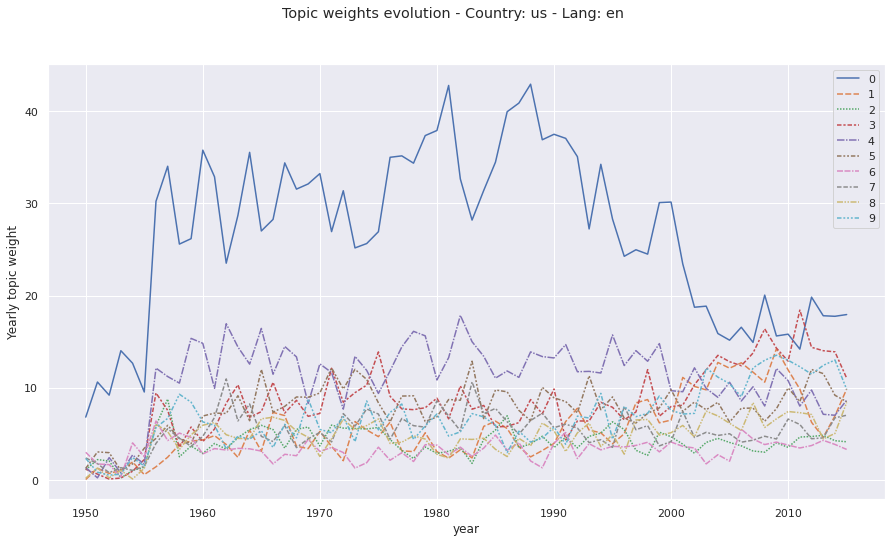

In [132]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=topics_distrib_evol)
plt.ylabel('Yearly topic weight')
plt.suptitle(f'Topic weights evolution - Country: {country} - Lang: {lang}') 

In [133]:
topic_evolution(8)

{1950: [('poor', 0.010866497012439358),
  ('shoot', 0.007923555404931979),
  ('fun', 0.006667150345159858),
  ('gun', 0.006526336257680587),
  ('pay', 0.006001905025232154),
  ('car', 0.005297065023654694),
  ('drink', 0.005242981469931211),
  ('mary', 0.005114397517124396),
  ('drop', 0.004715140821746465),
  ('store', 0.004664635380521048)],
 1960: [('poor', 0.010017782264915606),
  ('shoot', 0.008175533100564987),
  ('fun', 0.006953392656207987),
  ('gun', 0.006642304250690439),
  ('pay', 0.006287777480126302),
  ('car', 0.00549001475096257),
  ('drink', 0.005358945844252936),
  ('mary', 0.0051692869713732435),
  ('pretty', 0.00481138356132722),
  ('win', 0.004725890605780689)],
 1970: [('poor', 0.008123801167805384),
  ('shoot', 0.0073702616048679425),
  ('fun', 0.007118244088538175),
  ('gun', 0.006772031948085861),
  ('pay', 0.0063210806280440505),
  ('car', 0.005906145815467652),
  ('drink', 0.005685345101321976),
  ('black', 0.005043738170505585),
  ('pretty', 0.005002956721471

### Top songs within topics

In [134]:
def topic_top_songs(topic, n_songs):
    """
    For a given topic T, returns the songs that have the highest probability
    of being in T.
    """
    topic_songs_data = doc_topics_df[[topic, 'artist', 'title', 'year']]
    return topic_songs_data.nlargest(n_songs, topic).sort_values(by='year')

In [135]:
def print_songs_lyrics(song_index):
    """
    From the index of a song (index in songs_df),
    print its processed lyrics.
    """
    return songs_df.loc[song_index, 'doc']

In [143]:
topic_top_songs(5, 100).iloc[:60]

,5,artist,title,year
9,0.847150,patti page,tennessee waltz,1950
38,0.847122,patti page,tennessee waltz,1951
90,0.957143,eddie fisher,i need you now,1954
133,0.988889,al hibbler,unchained melody,1955
118,0.988889,les baxter,unchained melody,1955
155,0.995028,eddie fisher,dungaree doll,1956
279,0.768591,thurston harris,little bitty pretty one,1957
384,0.978049,pat boone,it's too soon to know,1958
450,0.970968,everly brothers,('til) i kissed you,1959
503,0.991089,jack scott,burning bridges,1960


In [148]:
lyrics_df[lyrics_df['title'] == 'yellow submarine']

,year,artist,title,country,lang,doc
2132,1966,beatles,yellow submarine,us,en,town bear live man sail sea tell life land sub...
2256,1966,the beatles,yellow submarine,fr,en,town bear live man sail sea tell life land sub...


In [153]:
lyrics_df[(lyrics_df['artist'].str.contains('beatles')) & (lyrics_df['country'] == 'fr')]

,year,artist,title,country,lang,doc
1568,1963,the beatles,she loves you,fr,en,love yeah yeah yeah love yeah yeah yeah love y...
1583,1963,the beatles,she loves you,fr,en,love yeah yeah yeah love yeah yeah yeah love y...
1584,1963,the beatles,from me to you,fr,en,da da da da da dum dum da da da da da da dum d...
1768,1964,the beatles,a hard day's night,fr,en,hard day night work like dog hard day night sl...
1789,1964,the beatles,all my loving,fr,en,close eye kiss tomorrow miss remember true awa...
1791,1964,the beatles,can't buy me love,fr,en,buy love love buy love buy diamond ring friend...
1801,1964,the beatles,i want to hold your hand,fr,en,oh yeah tell think understand wanna hold hand ...
1802,1964,the beatles,a hard day's night,fr,en,hard day night work like dog hard day night sl...
1809,1964,the beatles,can't buy me love,fr,en,buy love love buy love buy diamond ring friend...
1978,1965,the beatles,eight days a week,fr,en,ooh need love babe guess know true hope need l...


In [138]:
print_songs_lyrics(1014)

"feel depressed feel bad 'cause good girl love fraction oh little girl psychotic reaction feel like feel lonely night day love stay away need girl oh little girl like ride love satisfaction oh little girl psychotic reaction1embe"

## BERTopic

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from tqdm.notebook import trange, tqdm
from csv import DictReader, DictWriter

In [140]:
# Creates the same corpus as for GENSIM but as a list rather than a Corpus object
bert_corpus = [' '.join([word for word in doc.split(' ') if word in dictionary.token2id]) for doc in songs_df['doc']]

In [141]:
bert_dtm = BERTopic(min_topic_size=100, verbose=True)
bert_topics, _ = bert_dtm.fit_transform(bert_corpus)

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

RuntimeError: CUDA error: no kernel image is available for execution on the device

In [ ]:
freq = bert_dtm.get_topic_info()
freq

In [ ]:
bert_dtm.visualize_topics()

In [ ]:
topics_over_time = uk_dtm.topics_over_time(docs=bert_corpus, 
                                                topics=bert_topics, 
                                                timestamps=uk_dates, 
                                                global_tuning=True, 
                                                evolution_tuning=True, 
                                                nr_bins=20)

In [ ]:
fig = uk_dtm.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [ ]:
plt.savefig('figs/topics.png')